# Exercise: Stochastic FEM — Hexagonal Mirror Deformation

## Physical scenario
A hexagonal segment of a space telescope mirror is subjected to thermal and gravitational loads. The out-of-plane displacement $u(x,y)$ is modeled by the Poisson equation:
$$
-\ \nabla ^2 u = f(x,y)\quad\text{in }\Omega,
$$
where $u(x,y)$ is the displacement and $f(x,y)$ is the load function.

## Domain geometry
A regular hexagon centered at the origin with radius $R$ (distance from center to a vertex). The vertices are located at
$$
(x_k, y_k) = R\big(\cos(\tfrac{\pi k}{3}),\; \sin(\tfrac{\pi k}{3})\big),\quad k=0,1,2,3,4,5.
$$

## Boundary conditions
Homogeneous Dirichlet (clamped edges):
$$
u = 0 \quad\text{on }\partial\Omega.
$$

## Load function
Radial thermal gradient with directional asymmetry:
$$
f(x,y;\alpha,\beta,\gamma,\theta) = \alpha\big[1 + \beta\,r^2 + \gamma\cos(\phi-\theta)\big],
$$
where
- $r = \sqrt{x^2+y^2}$ is the radial distance,
- $\phi = \operatorname{atan2}(y,x)$ is the angular position,
- $\alpha$ is the load intensity [$N/m^2$],
- $\beta$ is the radial gradient coefficient [$1/m^2$],
- $\gamma$ is the amplitude of directional asymmetry (dimensionless, $0\le\gamma<1$),
- $\theta$ is the direction of maximum load [$rad$].

## Stochastic parameters
The parameters follow Gaussian distributions:
- $R \sim \mathcal{N}(0.6,\;0.01)$ [$m$]
- $\alpha \sim \mathcal{N}(100,\;10)$ [$N/m^2$]
- $\beta \sim \mathcal{N}(50,\;5)$ [$1/m^2$]
- $\gamma \sim \mathcal{N}(0.3,\;0.05)$ (dimensionless)
- $\theta \sim \mathcal{N}(\tfrac{\pi}{4},\;\tfrac{\pi}{12})$ [$rad$]

Here $\mathcal{N}(\mu,\sigma)$ denotes a normal distribution with mean $\mu$ and standard deviation $\sigma$, representing manufacturing or experimental uncertainty.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm


### Tarea 1: Solución determinista
Resuelva el problema de elementos finitos (FEM) utilizando los valores medios de todos los parámetros:

- Genere una malla triangular del dominio hexagonal.

- Resuelva el sistema lineal $K u = f$.

- Grafique el campo de desplazamientos $u(x,y)$.

- Grafique la función de carga $f(x,y)$.

- Reporte el desplazamiento máximo $u_{\max} = \max_\Omega |u(x,y)|$.

C:\Users\ameli\AppData\Local\Temp\ipykernel_29284\3722877379.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(self.elements))


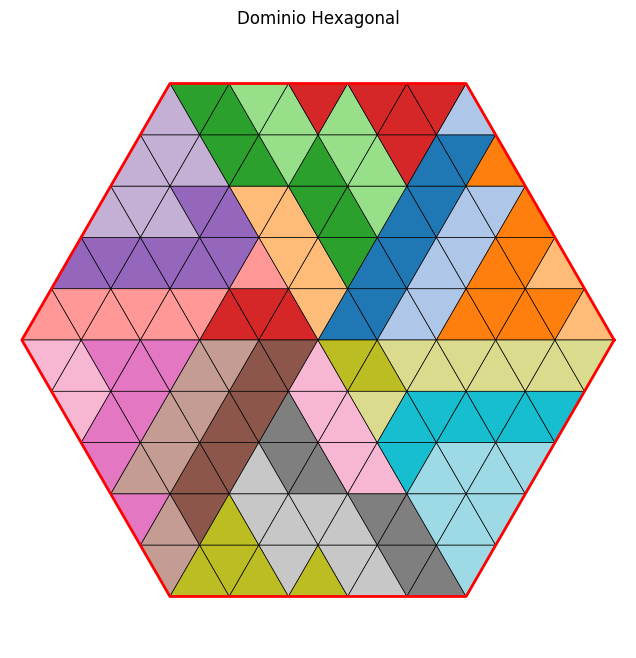

In [49]:
class HexagonalDomain:
    def __init__(self, R, m):
        self.R = R  # Radio del hexágono
        self.m = m  # Nivel de refinamiento (número de subdivisiones)
        self.hexagon_vertices = self.generate_hexagon_vertices()
        self.triangles = self.hexagon_triangles()
        self.nodes, self.elements = self.refine_triangles()
        self.area_value = self.area()

    def generate_hexagon_vertices(self):
        # Coordenadas de los 6 vértices del hexágono regular
        theta = np.arange(6) * np.pi / 3
        x = self.R * np.cos(theta)
        y = self.R * np.sin(theta)
        return np.column_stack((x, y))

    def hexagon_triangles(self):
        # Dividir el hexágono en 6 triángulos desde el centro
        center = np.array([[0.0, 0.0]])
        triangles = []
        for i in range(6):
            A = center[0]
            B = self.hexagon_vertices[i]
            C = self.hexagon_vertices[(i + 1) % 6]
            triangles.append((A, B, C))
        return triangles

    def refine_single_triangle(self, A, B, C):
        "Divide un triángulo en m×m subtriángulos"
        m = self.m
        nodes = []
        for i in range(m + 1):
            for j in range(m + 1 - i):
                # coordenadas baricéntricas
                P = (i / m) * B + (j / m) * C + (1 - (i + j) / m) * A
                nodes.append(P)
        nodes = np.array(nodes)

        # Crear conectividad (elementos)
        elements = []
        def idx(i, j):  # índice de nodo en la estructura triangular
            return int(i * (m + 1) - (i * (i - 1)) // 2 + j)

        for i in range(m):
            for j in range(m - i):
                n1 = idx(i, j)
                n2 = idx(i + 1, j)
                n3 = idx(i, j + 1)
                elements.append([n1, n2, n3])
                if j < m - i - 1:
                    n4 = idx(i + 1, j + 1)
                    elements.append([n2, n4, n3])

        return nodes, elements

    def refine_triangles(self):
        """Refina todos los triángulos del hexágono"""
        all_nodes = []
        all_elements = []
        offset = 0
        for (A, B, C) in self.triangles:
            nodes, elems = self.refine_single_triangle(A, B, C)
            elems = np.array(elems) + offset
            all_nodes.append(nodes)
            all_elements.append(elems)
            offset += len(nodes)
        all_nodes = np.vstack(all_nodes)
        all_elements = np.vstack(all_elements)
        return all_nodes, all_elements

    def area(self):
        self.area_value = []
        for element in self.elements:
            pts = self.nodes[element]
            A = pts[0]
            B = pts[1]
            C = pts[2]
            area = 0.5 * np.abs(
                A[0] * (B[1] - C[1]) +
                B[0] * (C[1] - A[1]) +
                C[0] * (A[1] - B[1])
            )

            self.area_value.append(area)
        return np.array(self.area_value)

    def plot(self):
        plt.figure(figsize=(8, 8))
        
        # Crear una paleta de colores
        cmap = cm.get_cmap('tab20', len(self.elements))
        
        for i, element in enumerate(self.elements):
            pts = self.nodes[element]
            color = cmap(i)  # color único
            polygon = plt.Polygon(pts, edgecolor='black', facecolor=color, lw=0.5)
            plt.gca().add_patch(polygon)

        # Dibujar el borde del hexágono
        plt.plot(
            np.append(self.hexagon_vertices[:, 0], self.hexagon_vertices[0, 0]),
            np.append(self.hexagon_vertices[:, 1], self.hexagon_vertices[0, 1]),
            'r-', lw=2
        )
        
        plt.xlim(-self.R - 0.2, self.R + 0.2)
        plt.ylim(-self.R - 0.2, self.R + 0.2)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Dominio Hexagonal')
        plt.axis('off')
        plt.show()

# Parámetros del dominio
R = 5  # Radio del hexágono
m = 5  # Refinamiento de malla
hex_domain = HexagonalDomain(R, m)
hex_domain.plot()

In [ ]:
# Resolvemos el problema de Poisson con FEM
class PoissonFEM:
    def __init__(self, domain, f):
        self.domain = domain
        self.f = f  # Función fuente
        self.K = None  # Matriz de rigidez
        self.F = None  # Vector de fuerzas
        self.u = None  # Solución
        
    def matriz_elemental(self, element):
        # Aquí se implementaría el cálculo de la matriz elemental
        pass

    def ensamblar_sistema(self):
        # Aquí se implementaría el ensamblaje de la matriz K y el vector F
        pass
    
    def aplicar_condiciones_frontera(self):
        # Aquí se implementarían las condiciones de frontera
        pass
    
    def solucionar(self):
        # Aquí se resolvería el sistema lineal Ku = F
        pass

# Task 2: Monte Carlo Analysis

Perform $N = 100$ simulations with random parameters:

1. Sampling: for each iteration $i = 1,\dots,100$:
   - Generate random samples $R_i, \alpha_i, \beta_i, \gamma_i, \theta_i$.
   - Solve the FEM problem.
   - Store $u_{\max,i}$ 

2. Statistical analysis: calculate and plot:
   - Histogram of the distribution of $u_{\max}$ and report its mean and standard deviation.
   - 95% confidence interval.

3. Sensitivity analysis:
   - Compute correlations between the parameters and the maximum deformation.
   - Identify which parameter has the largest influence.

# Task 3: Parametric Study

Select one parameter of your choice and perform a univariate analysis:

1. Fix all parameters at their mean values except the selected parameter.
2. Generate $N = 100$ random samples for the selected parameter only.
3. For each sample, solve the FEM problem and compute $u_{\max}$.
4. Plot $u_{\max}$ versus the selected parameter and discuss the observed functional relationship.

Conclude the exercise by analyzing the results in light of the order of magnitude of the wavelength in the visible spectrum.